In [2]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import yellowbrick
import eli5
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext watermark
%watermark -d -m -v -p numpy,matplotlib,seaborn,yellowbrick,pandas -g
print ('Current working dir : %s' % os.getcwd())

2020-07-09 

CPython 3.7.6
IPython 7.15.0

numpy 1.18.5
matplotlib 3.2.2
seaborn 0.10.1
yellowbrick 1.1
pandas 1.0.4

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : fbd32d399fa8e1246e79475de74675a7bbfe97d0
Current working dir : /Users/toddhendricks/Public/code/datascience/blm


In [8]:
# Convert excel workbook to csv
xls = pd.read_excel('/Users/toddhendricks/Downloads/DISP_AllStatesAndTerritories_06302020.xlsx', sheet_name = None)
list(xls.keys())[:5]
data = pd.concat(xls.values())
data.to_csv("dla_equipment_q220.csv", index=None)

In [15]:
df = (
     pd
     .read_csv(
        'dla_equipment_q220.csv',
        parse_dates = ['Ship Date']
     )
     .assign(
        federal_supply_class = lambda x: x["NSN"].apply(lambda y: y[:4]),
        year = lambda x: x["Ship Date"].apply(lambda y: y.year)
     )
)

In [16]:
profile = ProfileReport(df, title="Police Militarization Report", explorative=True)
profile.to_file("raw.html")

In [20]:
df.sample(5, random_state = 0)

,State,Station Name (LEA),NSN,Item Name,Quantity,UI,Acquisition Value,DEMIL Code,DEMIL IC,Ship Date,Station Type,federal_supply_class,year
96755,OH,WAYNE COUNTY SHERIFF'S OFFICE,1005-01-128-9936,"RIFLE,5.56 MILLIMETER",1,Each,749.00,D,1.0,2014-10-20,State,1005,2014
104395,SC,DNR LAW ENFORCEMENT DIVISION,1240-01-540-3690,"SIGHT,REFLEX",1,Each,321.00,D,1.0,2013-10-28,State,1240,2013
93627,OH,NELSONVILLE POLICE DEPT,2510-01-525-1646,"DOOR,VEHICULAR",1,Each,2830.33,Q,3.0,2011-02-07,State,2510,2011
102325,SC,AIKEN COUNTY SHERIFF OFFICE,1005-01-128-9936,"RIFLE,5.56 MILLIMETER",1,Each,749.00,D,1.0,2015-01-09,State,1005,2015
119966,TX,COMAL COUNTY SHERIFFS OFFICE,5855-01-228-0937,NIGHT VISION GOGGLE,1,Each,3578.00,F,1.0,2015-01-22,State,5855,2015


In [26]:
post_ferguson = data[
    lambda x: x["Ship Date"] > "2014-08-25"
]

In [27]:
print('''Since Michael Brown was killed, and following the Ferguson riots there have been {:,} total transfers of equipment that are still held by the police agency.
They total ${:,}.'''.format(
    len(post_ferguson),
    post_ferguson["Acquisition Value"].sum()
))

Since Michael Brown was killed, and following the Ferguson riots there have been 45,824 total transfers of equipment that are still held by the police agency.
They total $861,748,225.57.


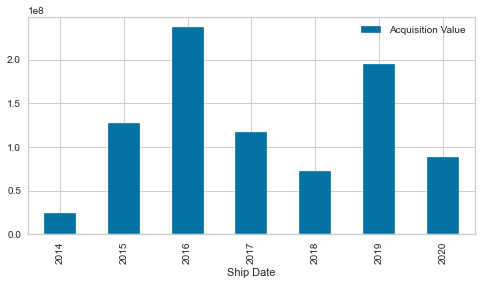

In [28]:
year_totals = (
    post_ferguson
    .groupby(pd.Grouper(key = "Ship Date", freq = "AS"))
    ["Acquisition Value"]
    .sum()
    .reset_index()
    .assign(**{ "Ship Date": lambda df: df["Ship Date"].dt.year })
    .set_index("Ship Date")
)

(
    year_totals
    .plot(
        kind="bar",
        figsize = (8, 4)
    )
)
pass

### South Carolina's share seemed way out of proportion. Looking into that in the cells below.

In [31]:
sc = post_ferguson[post_ferguson['State'] == 'SC'].sort_values(by='Ship Date', ascending=False)

In [38]:
sc_assault_gear = sc[sc['Item Name'].str.contains('ASSAULT')]

In [39]:
sc_rifles = sc[sc['Item Name'].str.contains('RIFLE')]

In [42]:
(sc['Acquisition Value'].sum() / post_ferguson["Acquisition Value"].sum()) *100

5.082200337695091

### MRAP's are quite excessive. It will be interesting to see where those are going. Looking into it below.

In [44]:
mraps = post_ferguson[
    lambda x: x["Item Name"] == "MINE RESISTANT VEHICLE"
]

In [45]:
mraps["Quantity"].sum()

509

In [50]:
mraps.groupby(by='year')["Quantity"].sum().to_frame()

KeyError: 'year'